In [ ]:
# import os
# import torch
# from PIL import Image
# from torchvision import transforms
# from SAM2.sam2.sam2.build_sam import build_sam2_video_predictor

# import numpy as np
# import matplotlib.pyplot as plt
# points = np.array([[210, 350]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([1], np.int32)


# # 4. Initialize model
# checkpoint = "checkpoints/sam2.1_hiera_base_plus.pt"
# model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
# predictor = build_sam2_video_predictor(model_cfg, checkpoint)

# # 5. Inference
# with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
#     # # Initialize with frames
#     state = predictor.init_state("../segstrong/SegSTRONGC_test/test/9/0/smoke/left")
    
#     # state = predictor.init_state("../test")



In [ ]:
import json
json.load(open("annotations/auto/val.json", "r"))['data/raw/SegSTRONGC_val/val/1/0/regular/left']



In [ ]:
import json
json.load(open("annotations/auto/test.json", "r"))['data/raw/SegSTRONGC_test/test/9/0/blood/left']

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2

# from json import load
# points = load(open("annotations/auto/test.json", "r"))
# annot = points['data/raw/SegSTRONGC_test/test/9/0/smoke/left']
# annot

# img = cv2.imread("../segstrong/SegSTRONGC_test/test/9/0/smoke/left/10.png")[:, :, ::-1]
# img = np.ascontiguousarray(img)

# for i in annot['0']:
#     print(i['x'], i['y'])
#     img = cv2.circle(img, (i['x'], i['y']), 10, (0, 255, 0), -1)
    
# for i in annot['1']:
#     print(i['x'], i['y'])
#     img = cv2.circle(img, (i['x'], i['y']), 10, (0, 0, 255), -1)
    
    
# plt.imshow(img)
# plt.show()

In [ ]:

# # 5. Inference
# with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
#     # Initialize with frames
#     # Apply prompt only on the first frame
#     for obj in annot:
#         obj_point = []
#         for i in annot[obj]:
#             obj_point.append([i['x'], i['y']])
#         obj_point = np.array(obj_point, dtype=np.float32)

#         #obj_point = np.array([[200, 300], [275, 175]], dtype=np.float32)
#         _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=state,
#     frame_idx=0,
#     obj_id=int(obj),
#     points=obj_point,
#     labels=np.ones(obj_point.shape[0], dtype=np.int32),
# )   
#         print("State objects ids:", state['obj_ids'])
    

#     # Optional: print first frame results
#     print(f"First frame, object_ids={out_obj_ids}, logits min, max, mean {out_mask_logits.shape} = {out_mask_logits.min()}, {out_mask_logits.max()}, {out_mask_logits.mean()}")
#     plt.imshow(out_mask_logits[0][0].cpu().numpy() > 0, cmap="gray")
#     plt.show()
#     # Propagate masks through video
#     for frame_idx, object_ids, masks in predictor.propagate_in_video(state):
#         print(f"Frame {frame_idx}: Got masks for object_ids {object_ids}")

#         plt.imshow(cv2.imread(f"../segstrong/SegSTRONGC_test/test/9/0/smoke/left/{frame_idx}.png")[:, :, ::-1])
#         mask = (masks[0] > 0) + (masks[1] > 0)
#         plt.imshow(mask[0].cpu().numpy() > 0, cmap="gray", alpha=0.1)
#         plt.show()
#         if frame_idx==10:
#             break
#         # You can save or visualize the masks here

In [ ]:
# for i in range(2):
#     plt.imshow(masks[i][0].cpu().numpy()>0)
#     plt.show()

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

PATH = "../segstrong"
TEST_PATH = os.path.join(PATH, "SegSTRONGC_test/test/9/")
VAL_PATH = os.path.join(PATH, "SegSTRONGC_val/val/1/")

test_vids = sorted(os.listdir(TEST_PATH), key=lambda x: int(x))
val_vids = sorted(os.listdir(VAL_PATH), key=lambda x: int(x))

print(test_vids, val_vids)

set_ = []

DOMAINS = ['blood', 'bg_change', 'regular', 'smoke', 'low_brightness']

for vids in [test_vids, val_vids]:
    temp_set = {}
    for domain in DOMAINS+['ground_truth']:
        temp_set[domain] = []
        for path in vids:
            path = os.path.join(TEST_PATH, path)
            temp_path = os.path.join(path, domain)
            
            for view in ['left', 'right']:
                temp_set[domain].append([])
                for img in os.listdir(os.path.join(temp_path, view)):
                    temp_set[domain][-1].append(os.path.join(temp_path, view, img))
                    
                temp_set[domain][-1] = sorted(temp_set[domain][-1], key=lambda x: int(x.split('/')[-1].split('.')[0]))
                
    set_.append(temp_set)
    
test_set, train_set = tuple(set_)
test_gt, train_gt = test_set['ground_truth'], train_set['ground_truth']
del test_set['ground_truth'], train_set['ground_truth']
        

['0', '1', '2'] ['0', '1', '2']


In [5]:
import cv2
from PIL import Image as PILImage
from iopath.common.file_io import g_pathmgr

with g_pathmgr.open(test_set['blood'][0][0], "rb") as fopen:
    img = PILImage.open(fopen).convert("RGB")
    
## convert mask to black and white
mask = cv2.imread(test_gt[0][0], 0)
# mask = np.where(mask > 0, 255, 0).astype(np.uint8)
objects = cv2.connectedComponents(mask)

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import logging
import random
from copy import deepcopy
from tqdm.auto import tqdm
import numpy as np

import torch
from iopath.common.file_io import g_pathmgr
from PIL import Image as PILImage
from torchvision.datasets.vision import VisionDataset
from SAM2.sam2.training.utils.data_utils import Frame, Object, VideoDatapoint


class VOSDataset(VisionDataset):
    def __init__(
        self,
        transforms,
        videos,
        gt_frames,
    ):
        self.vidoes = videos
        self.gt_frames = gt_frames
        self._transforms = transforms
        self.cache_gt = {}

    def _get_datapoint(self, idx):
        # start_frame = np.random.randint(0, len(self.video_dataset[idx]) - 10)
        # end_frame = np.random.randint(start_frame + 5, len(self.video_dataset[idx]))
        start_frame, end_frame = 0, 3 #len(self.vidoes[idx])-1
        video = self.vidoes[idx][start_frame:end_frame]
        gt_frames = self.gt_frames[idx][start_frame:end_frame]
        frame_num_list = list(range(start_frame, end_frame))
        
        images = []
        frame_idx = 0
        rgb_images = load_images(video)
        
        have_sampled = False
        prev_connected_comp = None
        for gt_mask, frame_num in tqdm(zip(gt_frames, frame_num_list)):
            w, h = rgb_images[frame_num].size
            images.append(
                Frame(
                    data=rgb_images[frame_num],
                    objects=[],
                )
            )
            
            if f"{gt_mask}_{frame_num}" in self.cache_gt:
                objects = self.cache_gt[f"{gt_mask}_{frame_num}"]
            else:
                mask = cv2.imread(gt_mask, 0)
                objects = cv2.connectedComponents(mask)
                self.cache_gt[f"{gt_mask}_{frame_num}"] = deepcopy(objects)
                
            #     print("mask")
            #     plt.imshow(mask)
            #     plt.show()
                
            # print("init")
            # plt.imshow(objects[1])
            # plt.show()
            objects = objects[1]
            class_, class_count = np.unique(objects, return_counts=True)
            bg_class = class_[np.where(class_count == np.max(class_count))[0][0]]
            class_ = class_.tolist()
            
            if bg_class!=0:
                objects+=1
                objects[objects==0] = 5
                objects[objects==bg_class] = 0
                objects[objects==5] = bg_class
                bg_class = 0
                
            class_.remove(bg_class)
            
            
            if not have_sampled:
                # sample = np.random.choice(2)+1 # 1 or 2
                sample = 2
                sampled_objs = np.random.choice(class_, sample, replace=False)
                have_sampled = True
            else:
                ### calc iou and make sure obj id doesnt change due to connected comp random label allocation
                
                prev_connected_comp_temp = deepcopy(prev_connected_comp)
                objects_temp = deepcopy(objects)
                prev_connected_comp[prev_connected_comp!=1] = 0
                objects[objects!=1] = 0
                iou1 = np.logical_and(prev_connected_comp, objects)
        
                prev_connected_comp = deepcopy(prev_connected_comp_temp)
                objects = deepcopy(objects_temp)
                
                prev_connected_comp[prev_connected_comp==1] = 3
                prev_connected_comp[prev_connected_comp==2] = 1
                prev_connected_comp[prev_connected_comp==3] = 2
                prev_connected_comp[prev_connected_comp!=1] = 0
                objects[objects!=1] = 0
                
                iou2 = np.logical_and(prev_connected_comp, objects)
                objects = deepcopy(objects_temp)
                
                if iou2.sum() > iou1.sum():
                    print("swapped!!")
                    objects[objects==1] = 3
                    objects[objects==2] = 1
                    objects[objects==3] = 2
                    
                    
            prev_connected_comp = objects
            # print("final")
            # plt.imshow(objects)
            # plt.show()
            
            for objs in sampled_objs:
                mask = np.where(objects == objs, 1, 0).astype(np.uint8)
                images[frame_idx].objects.append(
                    Object(
                        object_id=objs-1,
                        frame_index=frame_num,
                        segment= torch.Tensor(mask),
                    )
                )
            
            frame_idx += 1

            
        datapoint = VideoDatapoint(
            frames=images,
            video_id=idx,
            size=(h, w),
        )

        datapoint = self._transforms(datapoint)
        return datapoint

    def __getitem__(self, idx):
        return self._get_datapoint(idx)

    def __len__(self):
        return len(self.vidoes)


def load_images(frames):
    all_images = []
    for path in tqdm(frames):
        with g_pathmgr.open(path, "rb") as fopen:
            all_images.append(PILImage.open(fopen).convert("RGB"))

    return all_images





from SAM2.sam2.training.dataset.transforms import (
    ComposeAPI,
    RandomHorizontalFlip,
    RandomAffine,
    RandomResizeAPI,
    ColorJitter,
    RandomGrayscale,
    ToTensorAPI,
    NormalizeAPI
)


train_transform = ComposeAPI([
    RandomHorizontalFlip(consistent_transform=True),
    # RandomAffine(
    #     degrees=25,
    #     shear=20,
    #     image_interpolation="bilinear",
    #     consistent_transform=True,
    # ),
    # ColorJitter(
    #     consistent_transform=True,
    #     brightness=0.1,
    #     contrast=0.03,
    #     saturation=0.03,
    #     hue=None,
    # ),
    # RandomGrayscale(
    #     consistent_transform=True,
    #     p=1,
    # ),
    RandomResizeAPI(
        sizes=1024,
        square=True,
        consistent_transform=True,
    ),
    # ColorJitter(
    #     consistent_transform=False,
    #     brightness=0.1,
    #     contrast=0.05,
    #     saturation=0.05,
    #     hue=None,
    # ),
    ToTensorAPI(),
    NormalizeAPI(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


dataset = VOSDataset(transforms=train_transform, 
                     videos=test_set['regular'], 
                     gt_frames=test_gt)

a = next(iter(dataset))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


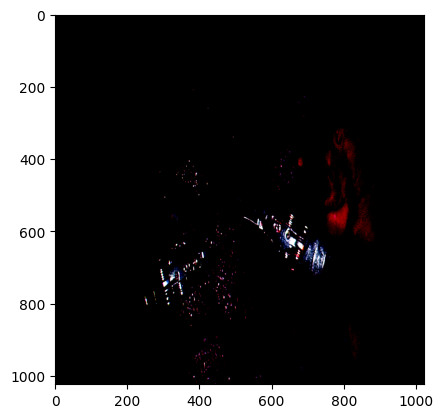

In [7]:
a.frames[0].data ## 3, 1024, 1024
a = a.frames[0].data.permute(1, 2, 0).cpu().numpy()
plt.imshow(a)

In [1]:

from SAM2.sam2.training.model.sam2 import SAM2Train
import importlib
import SAM2.sam2.training.utils.data_utils
importlib.reload(SAM2.sam2.training.model.sam2)
from SAM2.sam2.training.model.sam2 import SAM2Train
from sam2_model import get_model

In [4]:
from sam2_dataset import get_dataloader
from lora_qkv import wrap_decoder_lora, wrap_image_encoder_lora
from omegaconf import OmegaConf

config = OmegaConf.load("config.yaml")

from sam2_model import _load_checkpoint


model = get_model(config)
_load_checkpoint(model, config.model.checkpoint)

wrap_decoder_lora(model, 8)
wrap_image_encoder_lora(model, 8)

model = model.to("cuda")

config.dataset.path = "../segstrong"
train_loader, val_loader = get_dataloader("regular", config)

batch = next(iter(train_loader))
batch = batch.to(
                "cuda"
            ) 

import torch
model.training = True
with torch.no_grad():
    output = model(batch)
targets = batch.masks

from SAM2.sam2.training.loss_fns import MultiStepMultiMasksAndIous
weight_dict = {'loss_mask': 20,
                'loss_dice': 1,
                'loss_iou': 1,
                'loss_class': 1}

criterion = MultiStepMultiMasksAndIous(weight_dict=weight_dict)
loss = criterion(output, targets)

['0', '1', '2'] ['0', '1', '2']


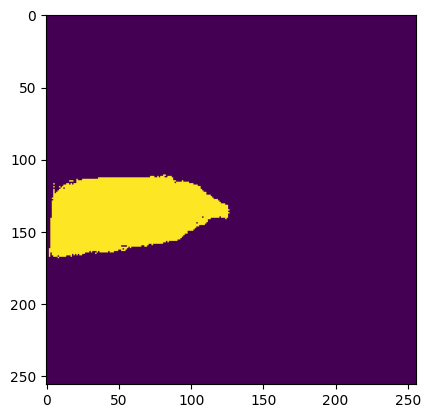

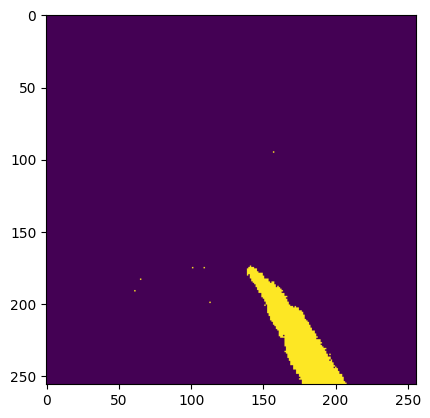

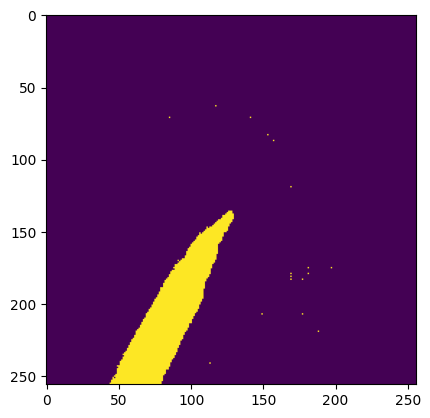

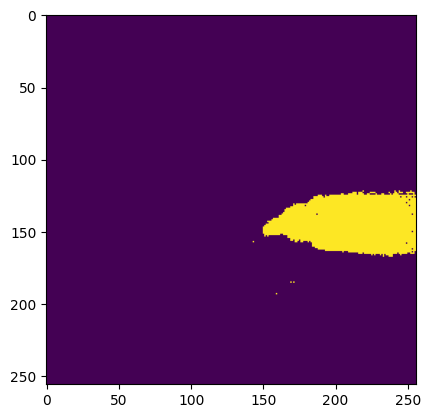

In [11]:
import matplotlib.pyplot as plt
for frame in output[1]['multistep_pred_masks']:
    plt.imshow(frame[0].cpu().numpy()>0)
    plt.show()
    

In [63]:
for o_idx in range(len(output)):
    for k in list(output[o_idx].keys()):
        if k not in ["multistep_pred_multimasks_high_res", "multistep_pred_ious", "multistep_object_score_logits"]:
            del output[o_idx][k]
        

criterion = MultiStepMultiMasksAndIous(weight_dict=weight_dict)
loss = criterion(output, targets)

In [64]:
loss

defaultdict(int,
            {'loss_mask': tensor(0.0010, device='cuda:0'),
             'loss_dice': tensor(0.0653, device='cuda:0'),
             'loss_iou': tensor(0.0012, device='cuda:0'),
             'loss_class': tensor(0., device='cuda:0'),
             'core_loss': tensor(0.0868, device='cuda:0')})

In [65]:
output[0]['multistep_pred_multimasks_high_res'][0].shape

torch.Size([4, 1, 1024, 1024])

In [59]:
torch.stack([torch.unsqueeze(output[i]['multistep_pred_multimasks_high_res'][0].squeeze(), 0) for i in range(len(output))]).shape

RuntimeError: stack expects each tensor to be equal size, but got [1, 4, 1024, 1024] at entry 0 and [1, 4, 3, 1024, 1024] at entry 1

torch.Size([4, 1, 1024, 1024])
i--
j---


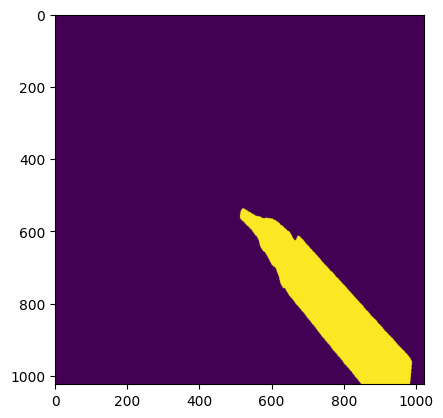

i--
j---


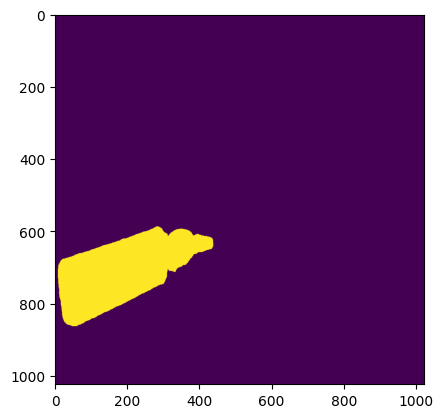

i--
j---


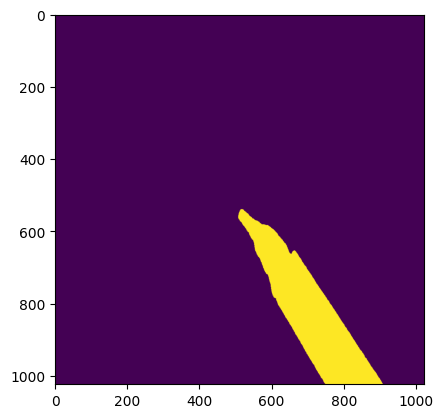

i--
j---


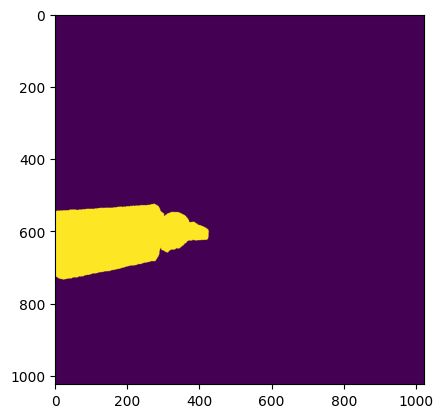

torch.Size([4, 3, 1024, 1024])
i--
j---


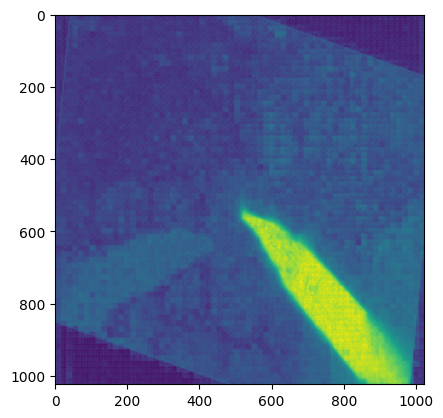

j---


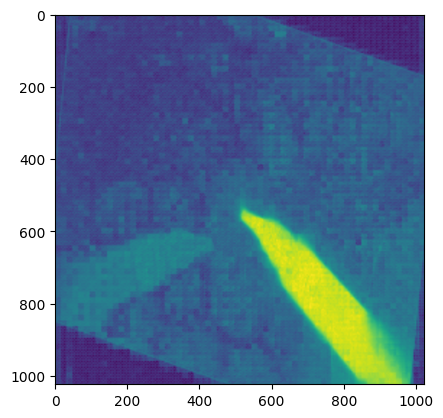

j---


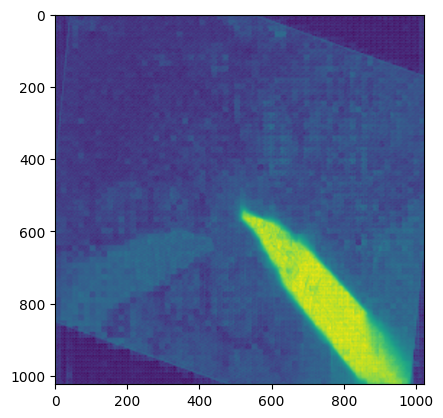

i--
j---


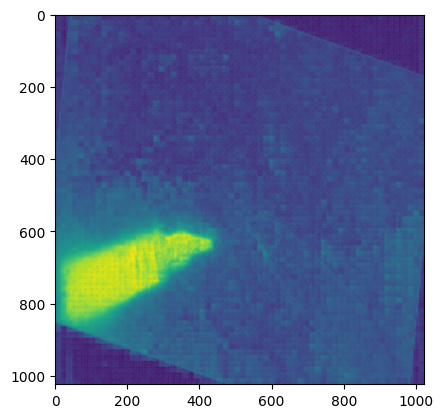

j---


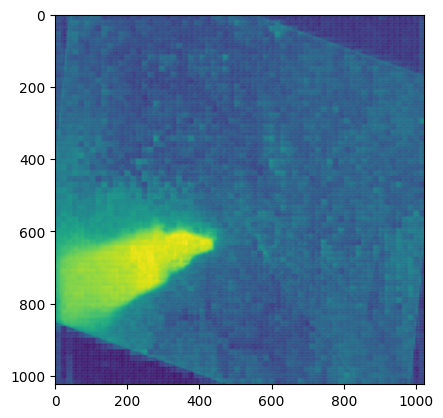

j---


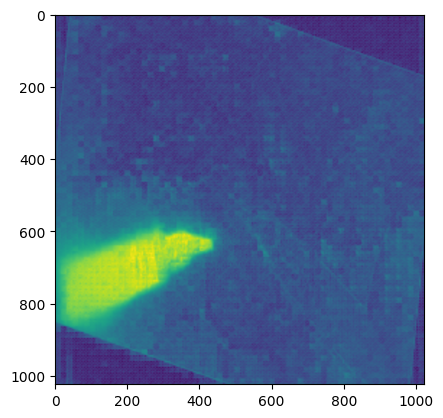

i--
j---


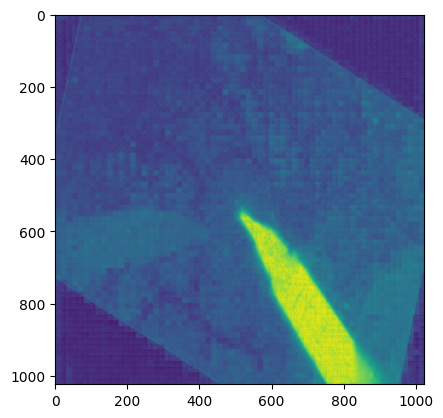

j---


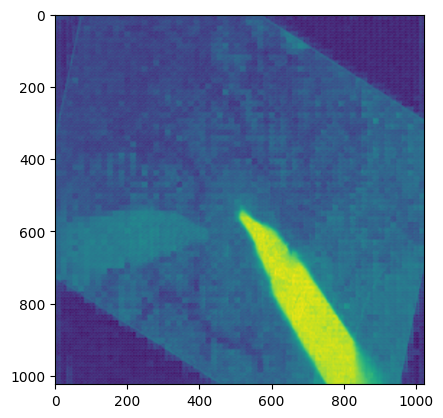

j---


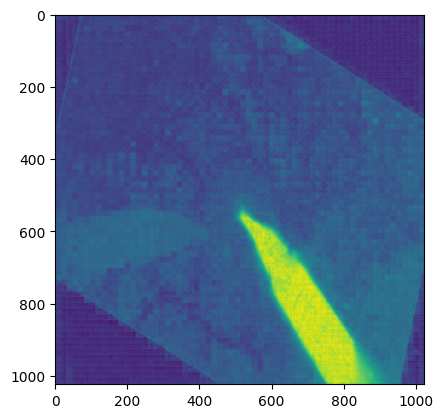

i--
j---


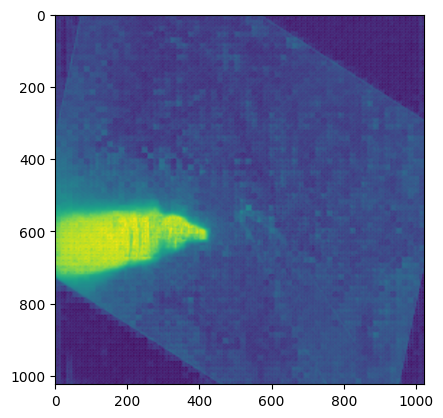

j---


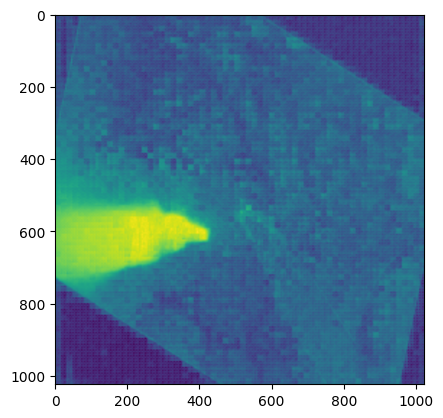

j---


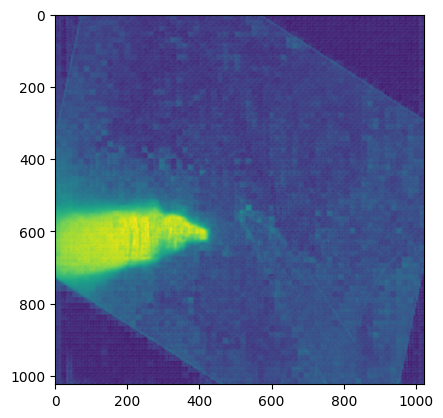

torch.Size([4, 3, 1024, 1024])
i--
j---


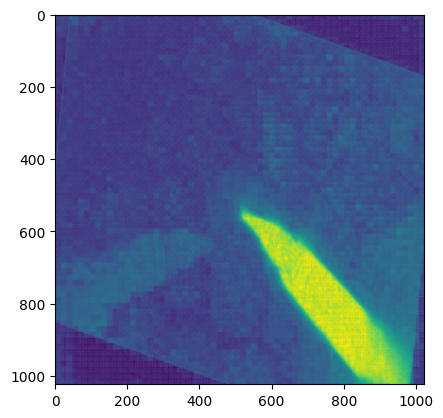

j---


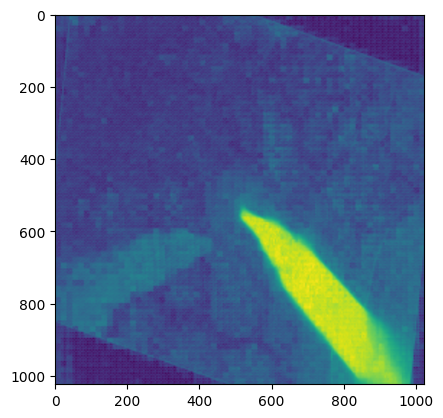

j---


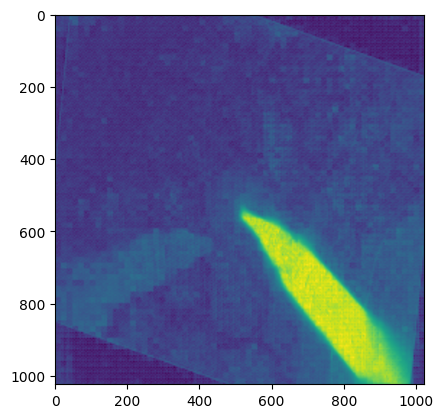

i--
j---


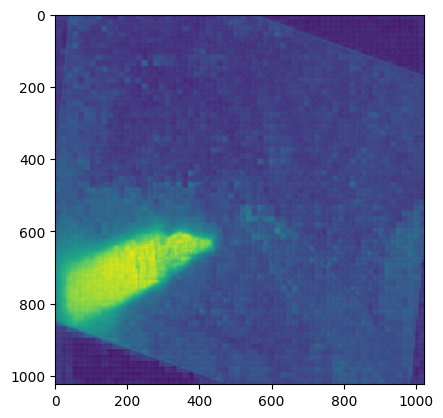

j---


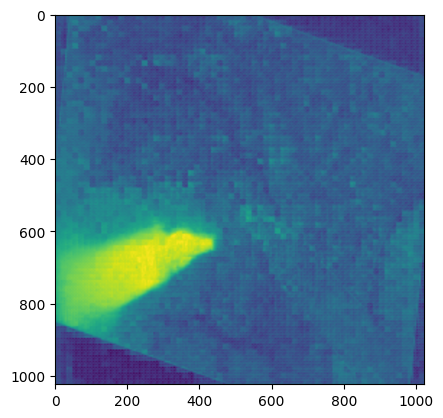

j---


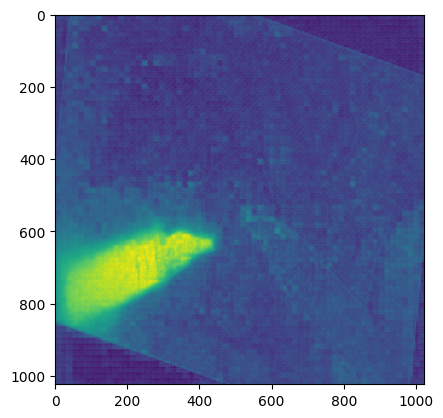

i--
j---


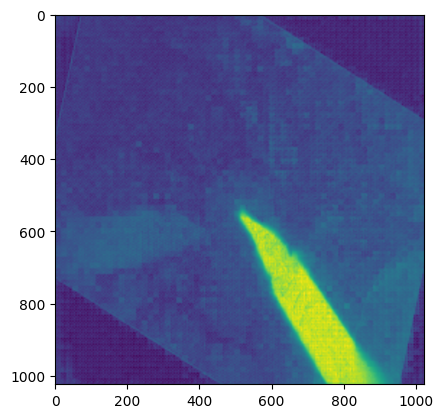

j---


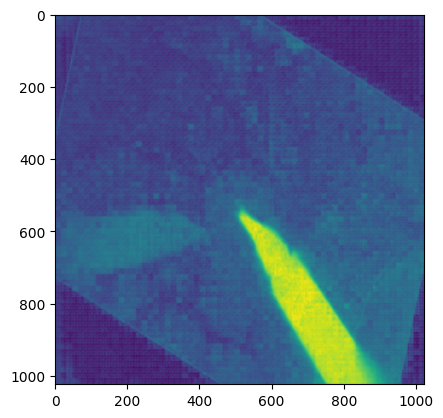

j---


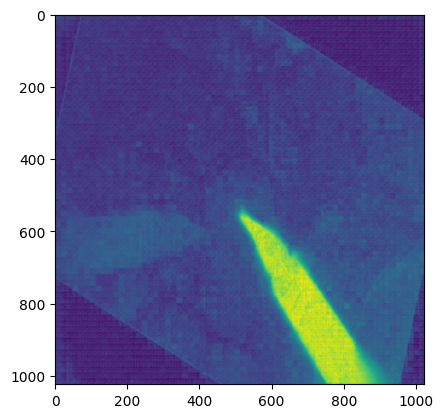

i--
j---


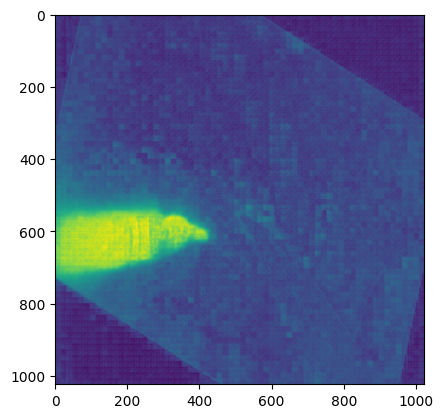

j---


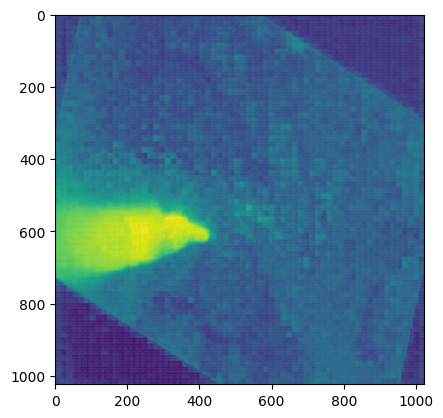

j---


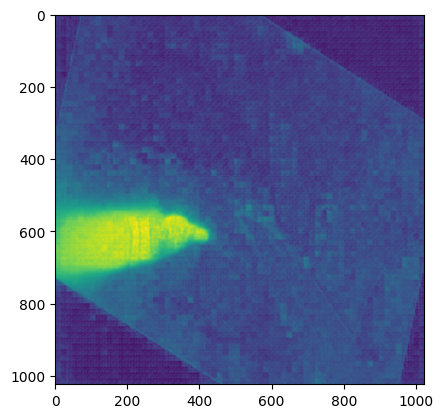

In [68]:
for i in range(len(output)):
    print(output[i]['multistep_pred_multimasks_high_res'][0].shape)
    for i in output[i]['multistep_pred_multimasks_high_res'][0]:
        print("i--")
        for j in i:
            print("j---")
            plt.imshow(j.cpu().numpy())
            plt.show()

In [ ]:
targets.shape

torch.Size([3, 4, 1024, 1024])

In [35]:
torch.stack([output[i]['multistep_pred_multimasks_high_res'].squeeze().unsqeeuze(0) for i in range(len(output))])

AttributeError: 'list' object has no attribute 'squeeze'

In [40]:
len(output)

3

In [39]:
output[0]['multistep_pred_multimasks_high_res']

[tensor([[[[-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.],
           ...,
           [-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.]]],
 
 
         [[[-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.],
           ...,
           [-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.]]],
 
 
         [[[-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.],
           ...,
           [-10., -10., -10.,  ..., -10., -10., -10.],
           [-10., -10., -10.,  ..., -10., -10., -10.],
     

In [27]:
for i in output[0]:
    print([j.shape for j in output[0][i]])

[torch.Size([4, 1, 1024, 1024])]
[torch.Size([4, 1])]
[torch.Size([4, 1])]


In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from SAM2.sam2.sam2.build_sam import build_sam2_video_predictor

import numpy as np
import matplotlib.pyplot as plt
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)


predictor = model
predictor.training = False
# 5. Inference
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    # # Initialize with frames
    state = predictor.init_state("../segstrong/SegSTRONGC_test/test/9/0/smoke/left")
    
    # state = predictor.init_state("../test")


import matplotlib.pyplot as plt
import numpy as np
import cv2

from json import load
points = load(open("annotations/auto/test.json", "r"))
annot = points['data/raw/SegSTRONGC_test/test/9/0/smoke/left']
annot

img = cv2.imread("../segstrong/SegSTRONGC_test/test/9/0/smoke/left/10.png")[:, :, ::-1]
img = np.ascontiguousarray(img)

for i in annot['0']:
    print(i['x'], i['y'])
    img = cv2.circle(img, (i['x'], i['y']), 10, (0, 255, 0), -1)
    
for i in annot['1']:
    print(i['x'], i['y'])
    img = cv2.circle(img, (i['x'], i['y']), 10, (0, 0, 255), -1)
    
    
plt.imshow(img)
plt.show()


# 5. Inference
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    # Initialize with frames
    # Apply prompt only on the first frame
    for obj in annot:
        obj_point = []
        for i in annot[obj]:
            obj_point.append([i['x'], i['y']])
        obj_point = np.array(obj_point, dtype=np.float32)

        #obj_point = np.array([[200, 300], [275, 175]], dtype=np.float32)
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=state,
    frame_idx=0,
    obj_id=int(obj),
    points=obj_point,
    labels=np.ones(obj_point.shape[0], dtype=np.int32),
)   
        print("State objects ids:", state['obj_ids'])
    

    # Optional: print first frame results
    print(f"First frame, object_ids={out_obj_ids}, logits min, max, mean {out_mask_logits.shape} = {out_mask_logits.min()}, {out_mask_logits.max()}, {out_mask_logits.mean()}")
    plt.imshow(out_mask_logits[0][0].cpu().numpy() > 0, cmap="gray")
    plt.show()
    # Propagate masks through video
    for frame_idx, object_ids, masks in predictor.propagate_in_video(state):
        print(f"Frame {frame_idx}: Got masks for object_ids {object_ids}")

        plt.imshow(cv2.imread(f"../segstrong/SegSTRONGC_test/test/9/0/smoke/left/{frame_idx}.png")[:, :, ::-1])
        mask = (masks[0] > 0) + (masks[1] > 0)
        plt.imshow(mask[0].cpu().numpy() > 0, cmap="gray", alpha=0.1)
        plt.show()
        if frame_idx==10:
            break
        # You can save or visualize the masks here

In [ ]:
import torch
from lora_qkv import wrap_image_encoder_lora, wrap_decoder_lora, save_lora_parameters, load_lora_parameters
wrap_decoder_lora(model, rank=8)
wrap_image_encoder_lora(model, rank=8)

torch.save(model.state_dict(), "model.pth")

In [ ]:
train_dict = torch.load("model.pth")    
for i in list(train_dict.keys()):
    # print(i)
    if '_a_q' in i or 'A_q' in i:
        print(i)

In [ ]:
model.image_encoder.trunk.blocks[22].attn.qkv ## 22, 23 

### save these parameters:

def save_lora_parameters(model, save_path):
    state_dict = model.state_dict()
    lora_param = {}
    for name, param in state_dict.items():
        if '_a_q' in name or 'A_q' in name or '_b_q' in name or 'B_q' in name:
            lora_param[name] = param
            
    torch.save(lora_param, save_path)
            
           
    
    
save_lora_parameters(model, "lora.pth")

def load_lora_parameters(model, load_path):
    error = model.load_state_dict(torch.load("lora.pth"), strict=False)
    for name in error.missing_keys:
        if '_a_q' in name or 'A_q' in name or '_b_q' in name or 'B_q' in name:
            raise ValueError(f"Custom LoRA Missing key in state_dict: {name}")

In [ ]:
from omegaconf import OmegaConf
from sam2_dataset import get_dataloader

config = OmegaConf.load("config.yaml")
config.distributed = False
train_loader, val_loader = get_dataloader("regular", config)

In [ ]:
img.shape

In [ ]:
import matplotlib.pyplot as plt
for data in train_loader:
    for mask, img in zip(data.masks[:2], data.img_batch[:2]):
        plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
        plt.show()
        plt.imshow(mask[0].cpu().numpy())
        plt.show()
        plt.imshow(mask[1].cpu().numpy())
        plt.show()

In [ ]:
data

In [ ]:
model.sam_mask_decoder.transformer.layers[0].self_attn.A_q #A_q, B_q, A_v, B_v



In [61]:
def _load_checkpoint(model, ckpt_path):
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cuda", weights_only=True)["model"]
        missing_keys, unexpected_keys = model.load_state_dict(sd)
        if missing_keys:
            logging.error(missing_keys)
            raise RuntimeError()
        if unexpected_keys:
            logging.error(unexpected_keys)
            raise RuntimeError()
        logging.info("Loaded checkpoint sucessfully")


_load_checkpoint(model, "checkpoints/sam2.1_hiera_base_plus.pt")

In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from SAM2.sam2.sam2.build_sam import build_sam2_video_predictor

import numpy as np
import matplotlib.pyplot as plt
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)


# 4. Initialize model
checkpoint = "checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

In [ ]:
wrap_image_encoder_lora(predictor, rank=8)
wrap_decoder_lora(predictor, rank=8)

In [ ]:
predictor.load_state_dict(torch.load("model.pth"), strict=True)

In [ ]:
model.sam_mask_decoder.transformer.layers[0].self_attn

In [ ]:
predictor

In [ ]:
def _load_checkpoint(model, ckpt_path):
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cuda", weights_only=True)["model"]
        missing_keys, unexpected_keys = model.load_state_dict(sd)
        if missing_keys:
            logging.error(missing_keys)
            raise RuntimeError()
        if unexpected_keys:
            logging.error(unexpected_keys)
            raise RuntimeError()
        logging.info("Loaded checkpoint sucessfully")


_load_checkpoint(model, "checkpoints/sam2.1_hiera_base_plus.pt")

In [ ]:
model.image_encoder.trunk.blocks[12:21]

In [ ]:
model.memory_attention.layers[0].cross_attn_image

# RoPEAttention

In [2]:
import os
path = "/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train"
vids = []
for folder in os.listdir(path):
    for vid in os.listdir(os.path.join(path, folder)):
        vids.append(os.path.join(path, folder, vid))

/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/3/0
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/3/2
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/4/0
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/4/1
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/4/2
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/5/0
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/5/2
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/7/0
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/7/1
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/8/1
/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/8/2


In [3]:
os.listdir('/media/frozenwolf/Seagate Backup Plus Drive/Segstrong/SegSTRONGC_train/3/0')

['ground_truth', 'regular']

In [ ]:
# import torch.nn.init as init
# import torch.nn as nn

# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         init.kaiming_uniform_(m.weight)
#         if m.bias is not None:
#             init.zeros_(m.bias)
#     elif isinstance(m, nn.Conv2d):
#         init.xavier_normal_(m.weight)
#         if m.bias is not None:
#             init.zeros_(m.bias)
#     elif isinstance(m, nn.BatchNorm2d):
#         init.ones_(m.weight)
#         init.zeros_(m.bias)
#     # Add more layer types as needed

# # Assuming `model` is your existing nn.Module
# model.apply(init_weights)


In [ ]:
plt.imshow(output[0]['pred_masks'][0][0].cpu().numpy())

In [ ]:
plt.imshow(output[2]['pred_masks'][0][0].cpu().numpy())

In [ ]:
# model.image_encoder, model.memory_encoder, model.sam_mask_decoder, model.sam_prompt_encoder

In [ ]:
model

In [ ]:
model.image_encoder.trunk.blocks[-1]

In [ ]:
sum(p.numel() for p in model.image_encoder.trunk.blocks[-1:].parameters() if p.requires_grad)

In [ ]:

import importlib
import SAM2.sam2.training.utils.data_utils
importlib.reload(SAM2.sam2.training.utils.data_utils)
from SAM2.sam2.training.utils.data_utils import collate_fn

from torch.utils.data import DataLoader
## import partial and for collate use partial and set dict key as all:
from functools import partial


dataset = VOSDataset(transforms=train_transform, 
                     videos=test_set['blood'], 
                     gt_frames=test_gt)


train_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=partial(collate_fn, dict_key='all'),
    pin_memory=False,
)

batch = next(iter(train_loader))
batch = batch.to(
                "cuda"
            ) 




In [ ]:
model.training = True
with torch.no_grad():
    output = model(batch)
targets = batch.masks

In [ ]:


from SAM2.sam2.training.loss_fns import MultiStepMultiMasksAndIous


        
weight_dict = {'loss_mask': 20,
                'loss_dice': 1,
                'loss_iou': 1,
                'loss_class': 1}

criterion = MultiStepMultiMasksAndIous(weight_dict=weight_dict)
loss = criterion(output, targets)

In [ ]:
loss

In [ ]:
criterion = MultiStepMultiMasksAndIous(weight_dict=weight_dict, supervise_all_iou= True,
                                    iou_use_l1_loss = True,
                                    pred_obj_scores = True,
                                    focal_gamma_obj_score = 0.0,
                                    focal_alpha_obj_score= -1.0,)

loss = criterion(output, targets)
loss

In [ ]:
len(loss)

In [ ]:
loss_key, loss = loss.popitem()
loss_key, loss

In [ ]:
plt.imshow(output[0]['pred_masks_high_res'][0][0].cpu().numpy())
plt.show()

plt.imshow(output[0]['pred_masks_high_res'][1][0].cpu().numpy())
plt.show()

In [ ]:
'''
([torch.Size([6, 256, 256, 256]),
  torch.Size([6, 256, 128, 128]),
  torch.Size([6, 256, 64, 64])],
 [torch.Size([6, 32, 256, 256]),
  torch.Size([6, 64, 128, 128]),
  torch.Size([6, 256, 64, 64])])
'''

[i.shape for i in backbone_out['vision_pos_enc']], [i.shape for i in backbone_out['backbone_fpn']]

